In [26]:
import torch
import matplotlib.pyplot as plt
import multiprocessing as mp
import sys
from pathlib import Path
from subprocess import check_output  # noqa: S404

import hydra
from hydra import compose, initialize
import pytorch_lightning as pl
import wandb
import torchshow as ts
from hydra.utils import instantiate
from lightning_utilities.core.rank_zero import rank_zero_only
from loguru import logger
from omegaconf import DictConfig, OmegaConf
from cargpt.utils.logging import setup_logging

from einops import rearrange
from einops.layers.torch import Rearrange
from xformers.components.attention.core import scaled_query_key_softmax

from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

import torchvision.transforms.functional as TVF
import numpy as np
from torch.nn import functional as F

from cargpt.components.episode import (
    EpisodeBuilder,
    Index,
    Modality,
    SpecialToken,
    Timestep,
    TokenType,
)

In [2]:
experiment ='notebook'
datamodule = 'gato-dry'

In [3]:
plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(32, 64))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [11]:
def setup(cfg: DictConfig):
    pl.seed_everything(
        cfg.seed,
        workers=True,
    )  # pyright: ignore[reportUnusedCallResult]

    models = []
    for model_name, model_cfg in cfg.models.items():

        logger.debug(f"instantiating {model_name}, {model_cfg._target_}")
        model: pl.LightningModule = instantiate(model_cfg)

        model.eval()

        models.append((f"{model_name}:{model_cfg._args_[0]}", model))

    logger.debug(f"instantiating datamodule {cfg.datamodule._target_}")
    # datamodule: pl.LightningDataModule = instantiate(cfg.datamodule)

    return models, []


In [5]:
def plot_attention(attentions, column_names, title=""):

    # Convert tensor to numpy array
    names, attn_matrices = list(zip(*attentions))
    n = len(attn_matrices)
    
    # Plot each attention map separately
    fig, axes = plt.subplots(1, n, figsize=(48, 4))

    for name, attn_matrix, ax in zip(names, attn_matrices, axes):

        tensor_np = attn_matrix.detach().cpu().numpy()
        im = ax.imshow(tensor_np, cmap='hot')  # You can use any colormap you prefer
        ax.set_xticks(range(tensor_np.shape[1]))  # Set the number of ticks equal to the number of columns
        ax.set_xticklabels(column_names, rotation=45)  # Set column names as tick labels with rotation
        ax.set_yticks([])  # Remove y-axis ticks
        ax.title.set_text(name)

        fig.colorbar(im, ax=ax)
        
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def compute_entropy(attn_mat):

    return - ((attn_mat + 1e-5) * torch.log(attn_mat + 1e-5)).sum(dim=2).mean(dim=1)


def compute_attention(inputs, model_name, model, batch_index, timestep, layer_index=0, discard_ratio=0.9):

    b, t = inputs.batch_size
    episode = model.episode_builder.build_episode(inputs)
    mask = model.objectives["inverse_dynamics"]._build_attention_mask(episode.index, episode.timestep)

    x = episode.packed_embeddings
    seq = torch.cat([x, x], dim=-1)

    attention_rollout = torch.eye(mask.data.shape[0]).unsqueeze(0).repeat([b, 1, 1])
    
    for idx in range(layer_index):

        block = model.encoder.encoders.blocks[idx]

        # just attention
        _, x2 = torch.chunk(seq, 2, dim=-1)
        x2 = block.f.net.norm(x2)
        query, key, value = block.f.net.sublayer.in_proj_container(x2, x2, x2)
        attn = scaled_query_key_softmax(query, key, att_mask=mask.data)
        del x2, query, key, value

        flat = attn.view(attn.size(0), -1)
        _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
        for idx, index in enumerate(indices):
            flat[idx, index] = 0

        # https://jacobgil.github.io/deeplearning/vision-transformer-explainability#attention-rollout
        attn = (attn + torch.eye(attn.size(-1)))
        attn /= attn.sum(1, keepdim=True)
        attention_rollout = torch.matmul(attention_rollout, attn)
        del attn

        # full forward for next layer
        seq = block(seq, f_args={"att_mask": mask.data})

    # normalize each row to 1.0
    attention_rollout /= attention_rollout.sum(2, keepdim=True)
    attn_reshaped = rearrange(attention_rollout, 'b (t_from s_from) (t_to s_to) -> b (t_from s_from) t_to s_to', t_from=t, t_to=t)
    attn_parsed = episode.index.parse(attn_reshaped)

    action_summary_attn = attn_parsed["special", "action_summary"][batch_index, timestep, 0, timestep, 182:]
    observation_summary_attn = attn_parsed["special", "observation_summary"][batch_index, timestep, 0, timestep, :180]
    observation_summary_non_image_attn = attn_parsed["special", "observation_summary"][batch_index, timestep, 0, timestep, 180:183]

    attention_dict = {}
    attention_dict["act_summ"] = action_summary_attn.reshape([1, -1])
    attention_dict["obs_summ"] = observation_summary_attn.reshape([10, 18])
    attention_dict["obs_summ_non_image"] = observation_summary_non_image_attn.reshape([1, -1])

    del x, episode

    return attention_dict

def plot_attentions(attention_dict):

    column_names = ["obs_summ", "obs_hist", "gas_pedal", "brake_pedal", "steering_angle", "act_summ"]
    plot_attention(attention_dict["act_summ"], column_names, title="action_summary")

    column_names = [f"{i}" for i in range(18)]
    plot_attention(attention_dict["obs_summ"], column_names, title="observation_summary")

    column_names = ["speed", "turn_signal", "obs_summ"]
    plot_attention(attention_dict["obs_summ_non_image"], column_names, title="observation_summary_non_image")

In [6]:
mp.set_start_method("spawn", force=True)
mp.set_forkserver_preload(["torch"])
setup_logging()

In [9]:
# context initialization
# https://hydra.cc/docs/advanced/compose_api/
with initialize(version_base=None, config_path=f"../config"):
    cfg = compose(config_name="train.yaml", overrides=[f"experiment={experiment}", f"datamodule={datamodule}", "paths.metadata_cache_dir=./yaak-datasets/metadata"])

In [12]:
models, datamodule = setup(cfg)

Seed set to 1337
2024-06-16 18:51:13.449 | DEBUG    | __main__ - instantiating obs_focal_logit_bias, cargpt.models.control_transformer.ControlTransformer.load_from_wandb_artifact ()
wandb: Downloading large artifact model-wk48ocbt:v2, 271.91MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6
2024-06-16 18:51:15.484 | DEBUG    | __main__ - instantiating obs_ce_logit_bias, cargpt.models.control_transformer.ControlTransformer.load_from_wandb_artifact ()
wandb: Downloading large artifact model-i9wpeqdb:v4, 271.91MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6
2024-06-16 18:51:17.555 | DEBUG    | __main__ - instantiating obs_regression, cargpt.models.control_transformer.ControlTransformer.load_from_wandb_artifact ()
wandb: Downloading large artifact model-sqe2e4lm:v2, 255.75MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6
2024-06-16 18:51:19.599 | DEBUG    | __main__ - instantiating image_only_ce_logit_bias, cargpt.models.control_transformer.

In [9]:
dataloader = datamodule.train_dataloader()
iterator = iter(dataloader)
mean = torch.tensor(dataloader.dataset.config.samples.transforms[1].mean).to(models[0][1].device).reshape([1, 3, 1, 1])
std = torch.tensor(dataloader.dataset.config.samples.transforms[1].std).to(models[0][1].device).reshape([1, 3, 1, 1])

In [10]:
batch = next(iterator)

In [11]:
batch_index = 12
timestep = 0
inputs = models[0][1]._build_input(batch).to(models[0][1].device)

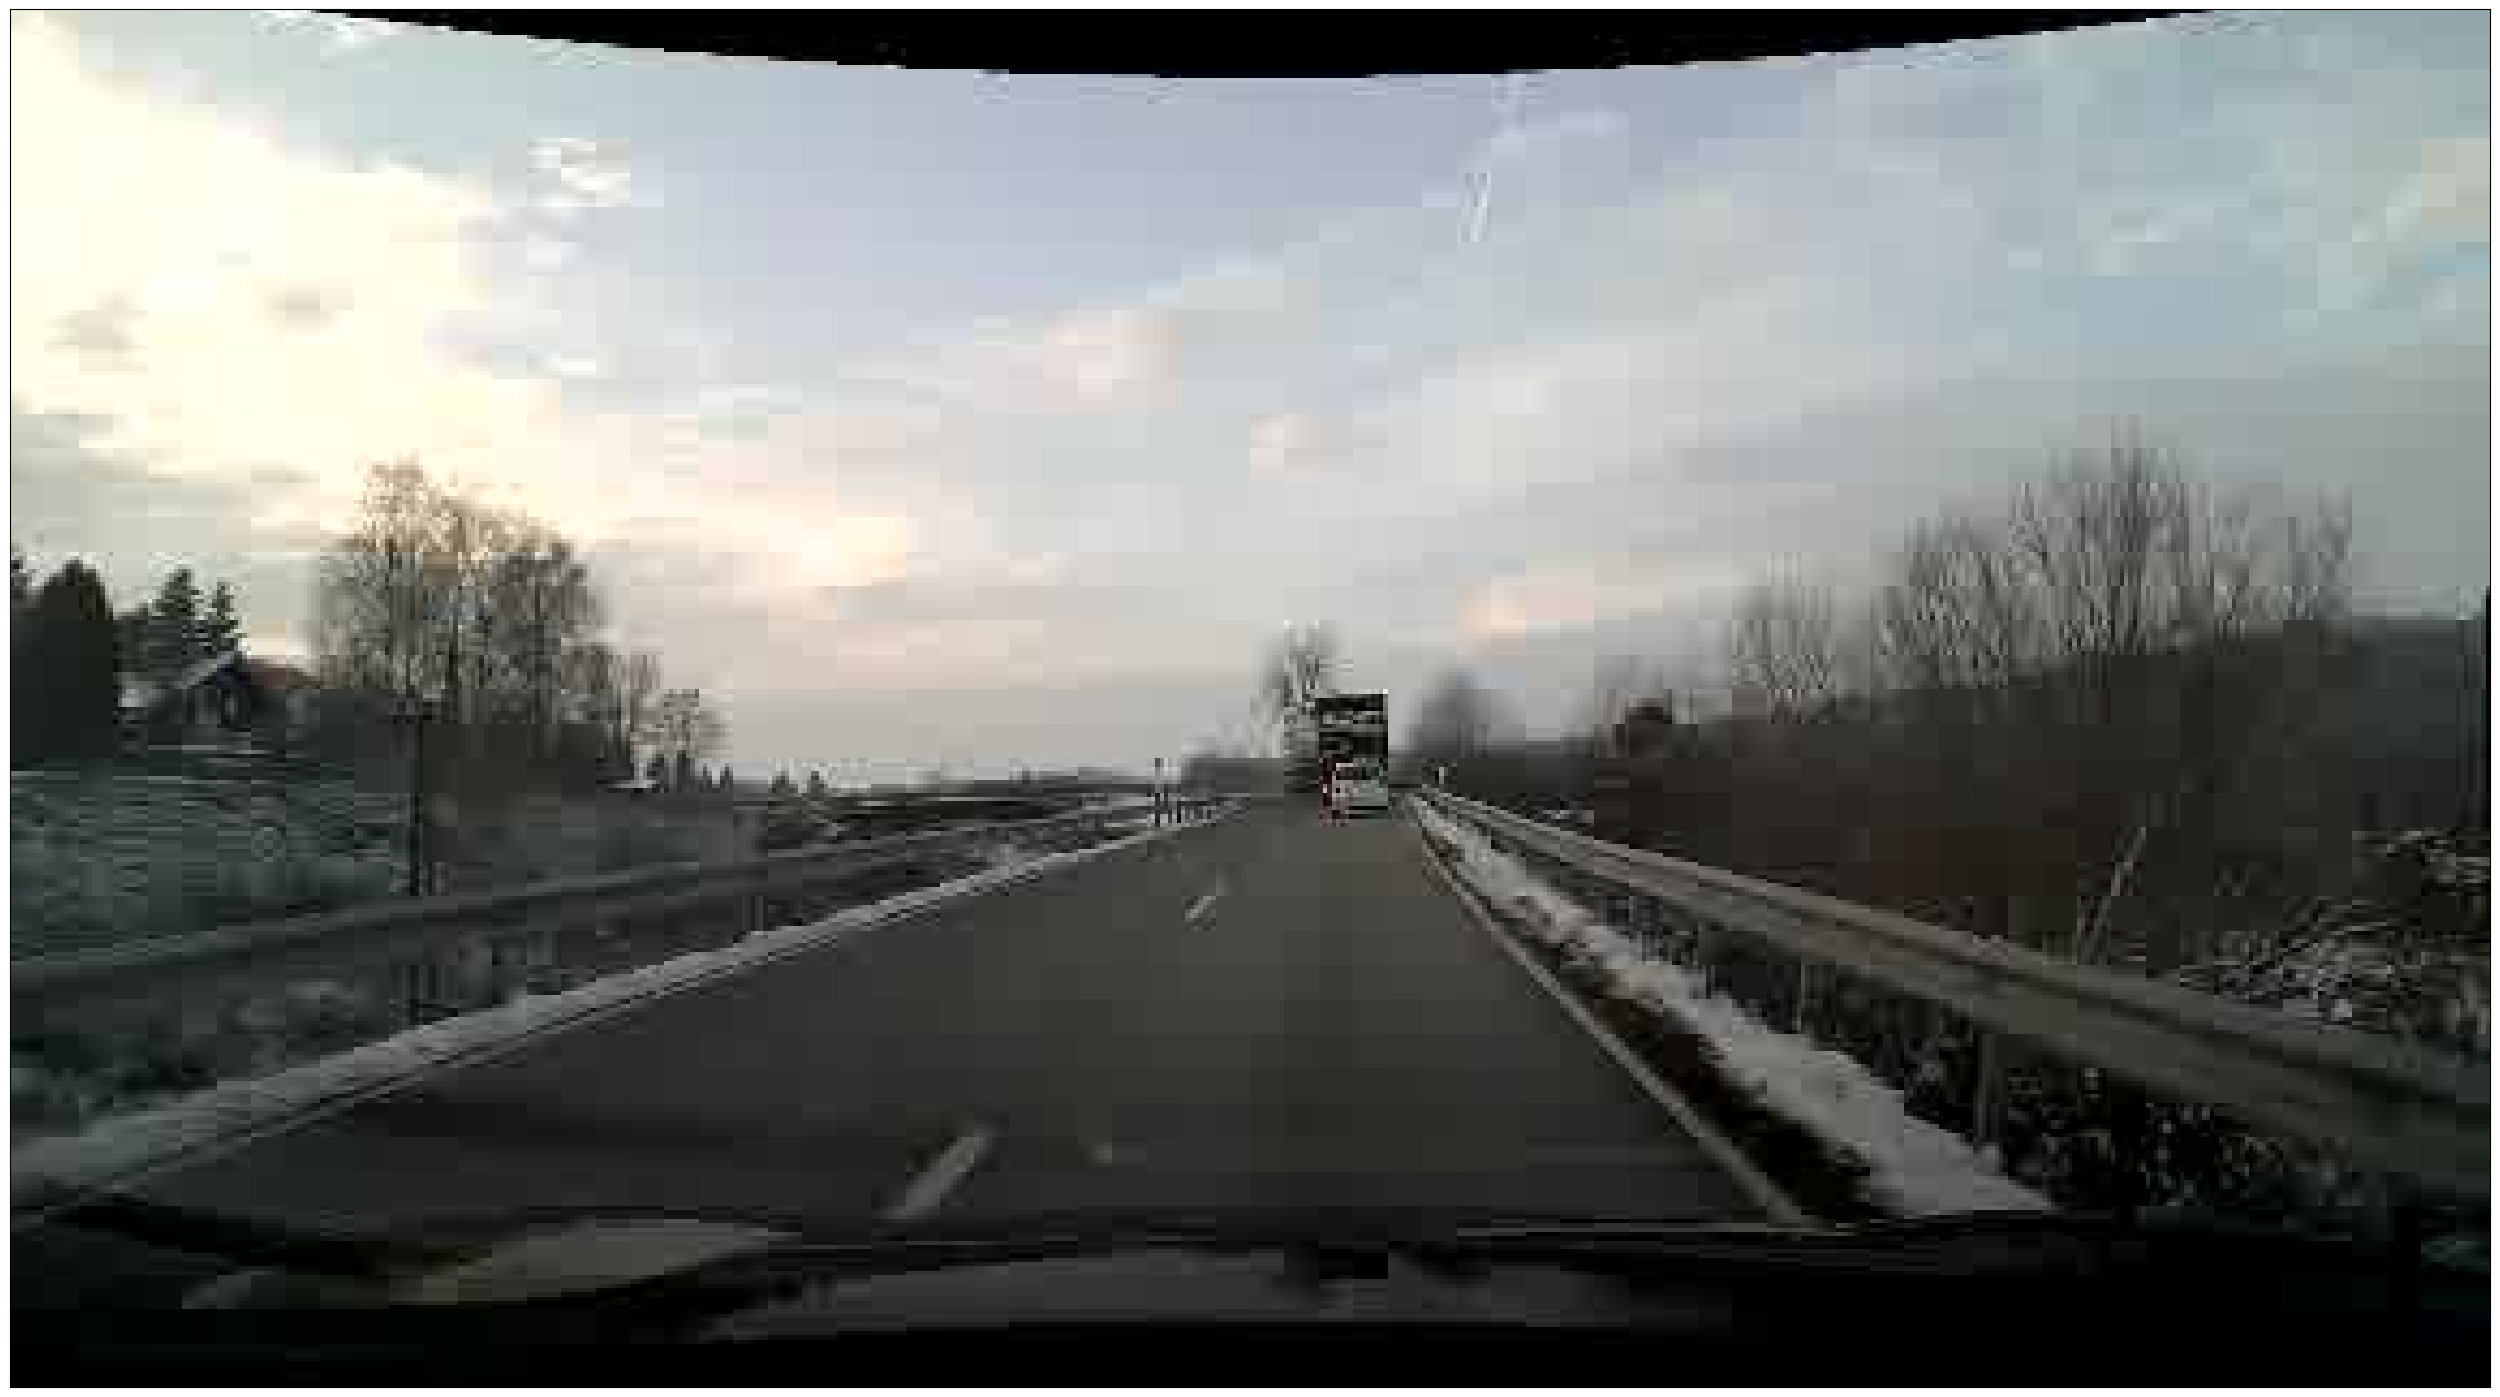

In [12]:
grid = make_grid((inputs["image", "cam_front_left"][batch_index, timestep].clone() * std) + mean)
show(grid)

In [13]:
attention_dict = {"act_summ": [], "obs_summ": [], "obs_summ_non_image": []}
for model_name, model in models:
    print(f"Computing attention for {model_name}")
    attentions = compute_attention(inputs, model_name, model, batch_index, timestep, layer_index=8, discard_ratio=0.5)
    for attn_type, attn in attentions.items():
        attention_dict[attn_type].append((model_name, attn))

Computing attention for obs_focal_logit_bias:yaak/cargpt/model-wk48ocbt:v2
Computing attention for obs_ce_logit_bias:yaak/cargpt/model-i9wpeqdb:v4
Computing attention for obs_regression:yaak/cargpt/model-sqe2e4lm:v2
Computing attention for image_only_ce_logit_bias:yaak/cargpt/model-q5a7g0yc:v1
Computing attention for obs_non_image_wo_obs_summ_regression:yaak/cargpt/model-5156kv3s:v1
Computing attention for obs_non_image_wo_obs_summ_ce_logit_bias:yaak/cargpt/model-zyzj72ks:v3


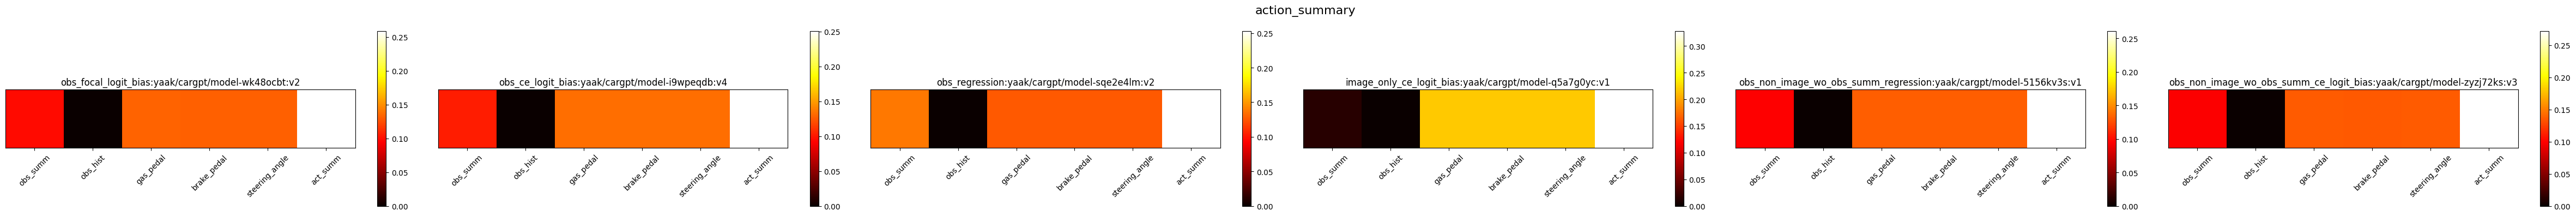

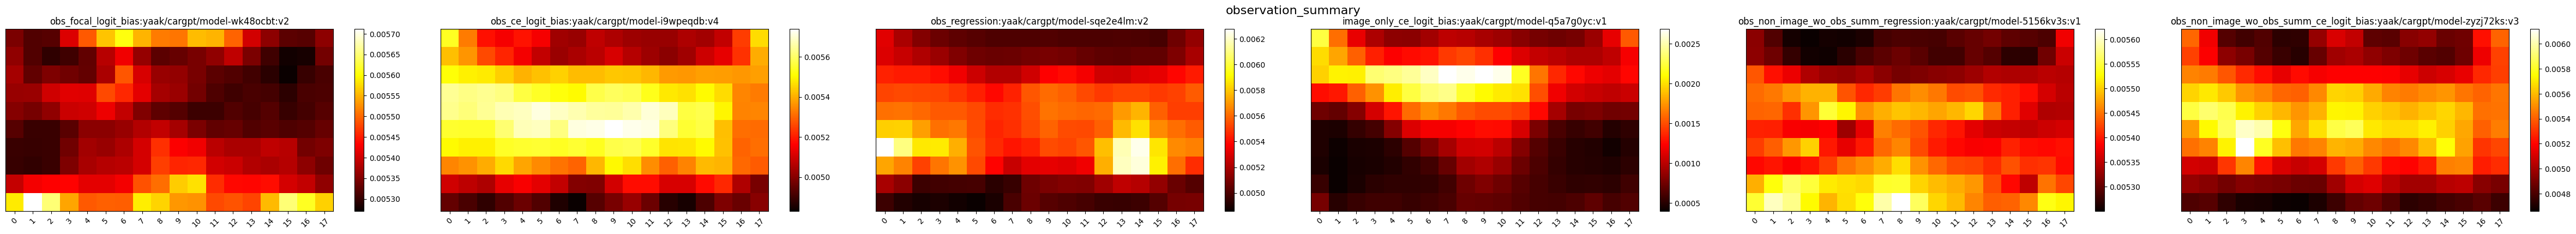

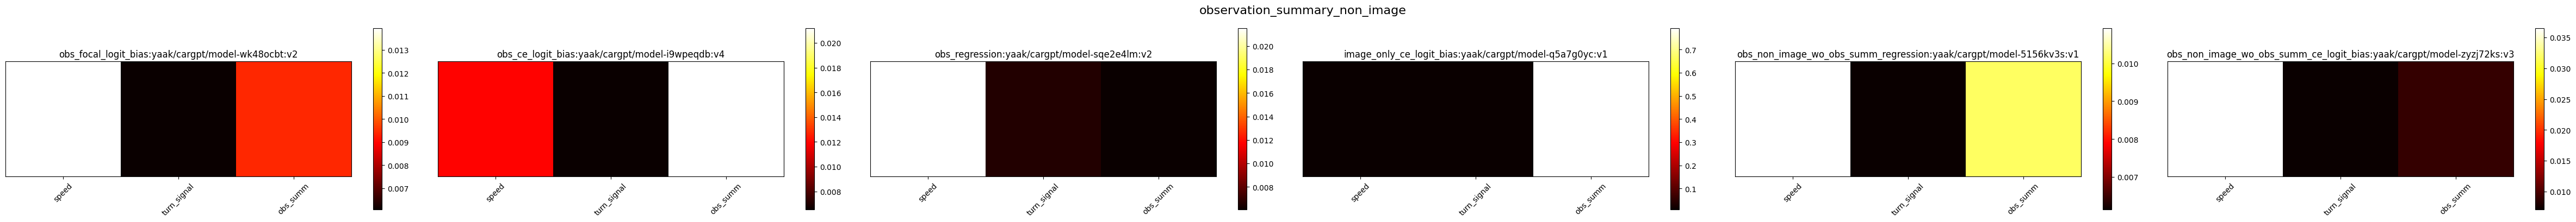

In [14]:
plot_attentions(attention_dict)

In [87]:
model_name, model = models[3]

In [88]:
model.episode_builder.position_encoding

ModuleDict(
  (observations): Embedding(182, 512)
  (actions): Embedding(1, 512)
  (special): Embedding(1, 512)
  (timestep): Embedding(6, 512)
)

In [89]:
model.episode_builder.embeddings['image'][2]

Rearrange('... h w d -> ... (h w) d')

In [90]:
timestep_pe = model.episode_builder.position_encoding.observations

In [91]:
n, d = timestep_pe.weight.shape

In [92]:
similarity = torch.full((n, n), fill_value=torch.nan)
for i in range(n):
    for j in range(i+1):
        similarity[i, j] = similarity[j, i] = F.cosine_similarity(timestep_pe.weight[[i]], timestep_pe.weight[[j]])

In [95]:
timestep_pe.weight.shape

torch.Size([182, 512])

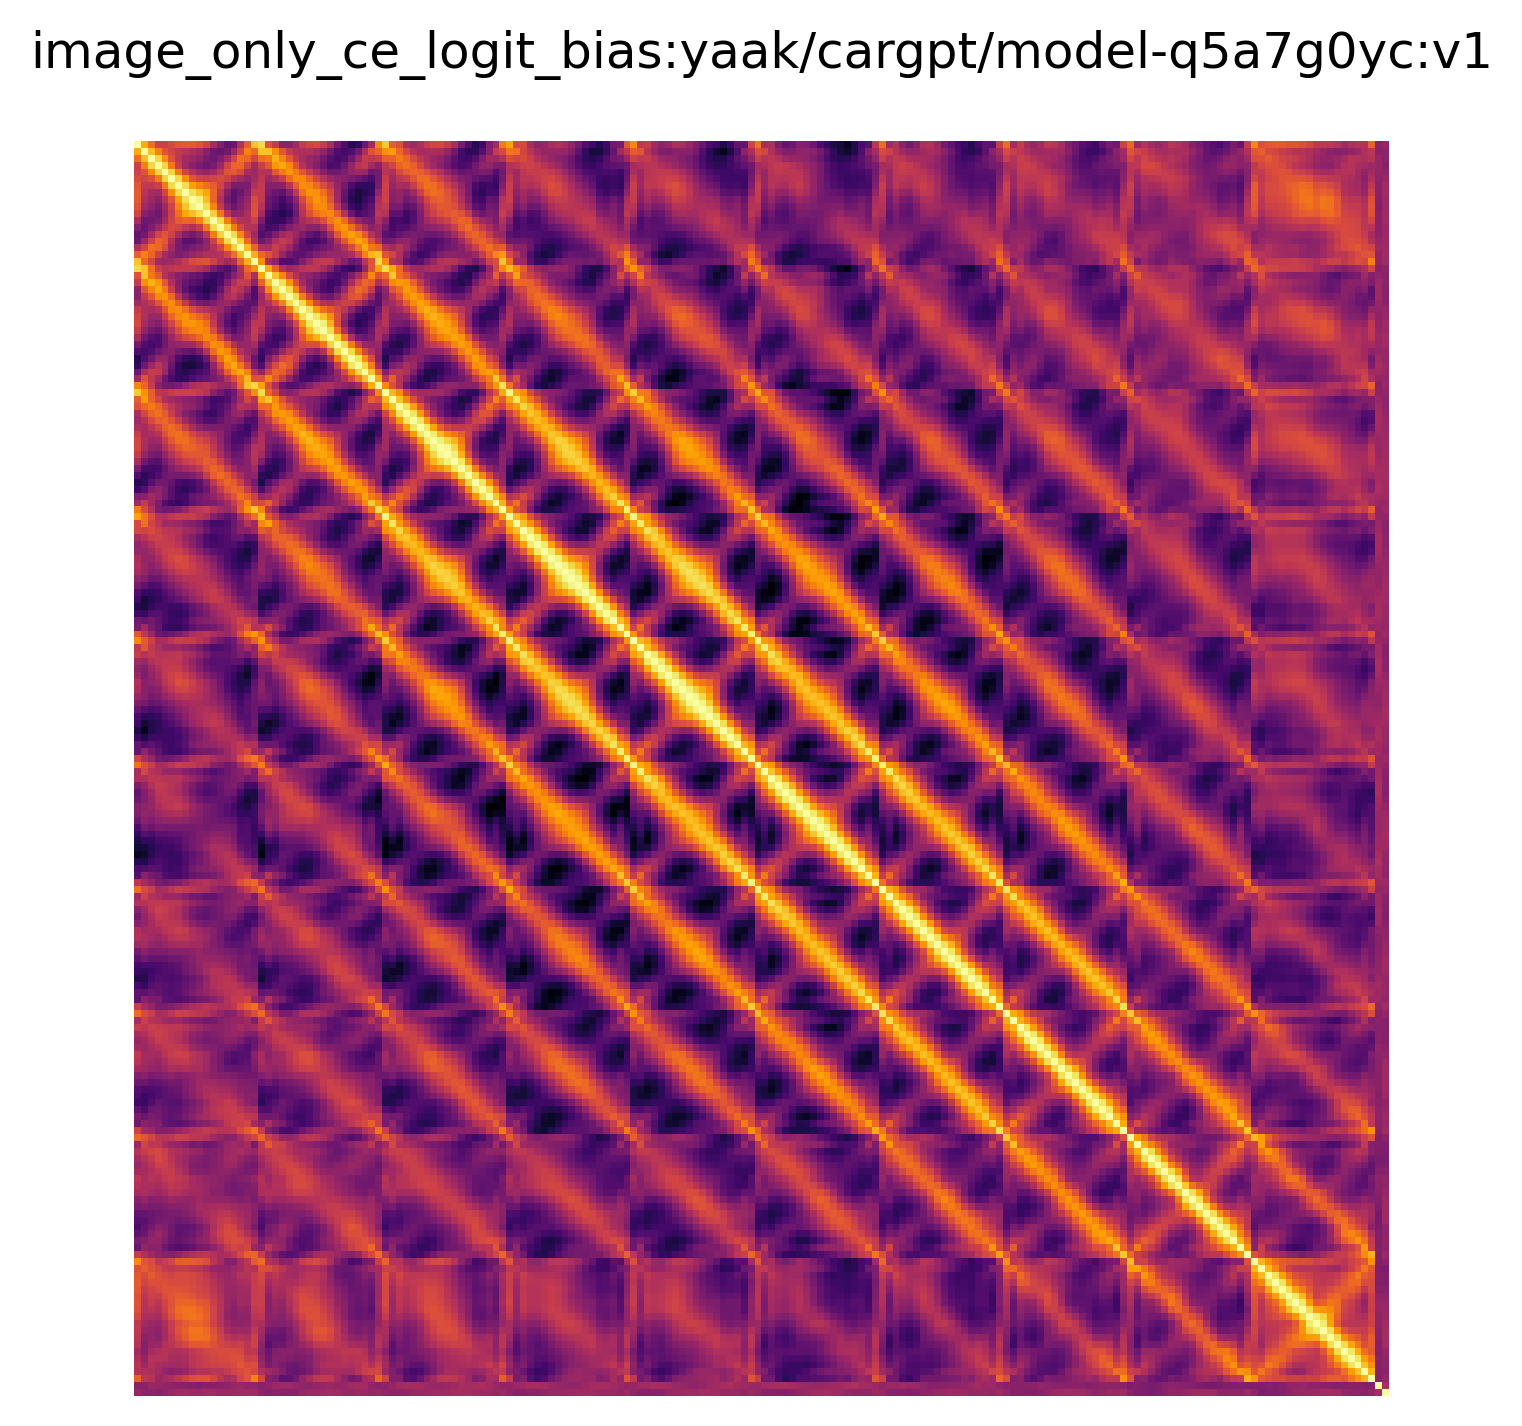

In [94]:
ts.show(similarity, suptitle=f'{model_name}', cmap='inferno', dpi=300)